##Заполнение пропущенных значений
В данном ноутбуке исследую различные техники заполнения пропусков в числовых колонках набора данных

In [ ]:
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

import missingno as msno

%matplotlib inline

In [ ]:
data = pd.read_csv('/content/googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
data[data.Price == 'Everyone'].index

Int64Index([10472], dtype='int64')

In [ ]:
data = data.drop([10472])
data.shape

(10840, 13)

In [ ]:
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [ ]:
# Эти признаки выкину, тк они не пригодятся для обучения модели
data.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

In [ ]:
data[data['Type'].isnull()].index.tolist()

[9148]

In [ ]:
#data[data['Rating'].isnull()].index.tolist()

In [ ]:
# Преобразую Type в бинарные значения
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

data['Type'] = data['Type'].map(type_cat)

In [ ]:
# Очистка признака size 
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

data["Size"] = data["Size"].map(change_size)

In [ ]:
# Очистка признака Installs
data['Installs']=data['Installs'].apply(lambda x: x.strip('+'))
data['Installs']=data['Installs'].apply(lambda x: x.replace(',',''))
data['Installs']=data['Installs'].replace('Free',np.nan)
data['Installs'] = data['Installs'].astype(float)

In [ ]:
# Очистка признака Price
data['Price'] = data['Price'].apply(lambda x: x.replace('$',''))
data['Price']=pd.to_numeric(data['Price'])

In [ ]:
# преобразую reviews к numeric
data['Reviews'] = data['Reviews'].astype(float)

In [ ]:
# Закодирую категориальные признаки в числовые
le = LabelEncoder()
content_rating = data['Content Rating']

category = le.fit_transform(data['Category'].dropna())
genres = le.fit_transform(data['Genres'].dropna())
cont_r = le.fit_transform(data['Content Rating'].dropna())
data['Category_num'] = category
data['Genres_num'] = genres
data['Content Rating'] = cont_r

In [ ]:
data.isnull().sum()

Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Category_num         0
Genres_num           0
dtype: int64

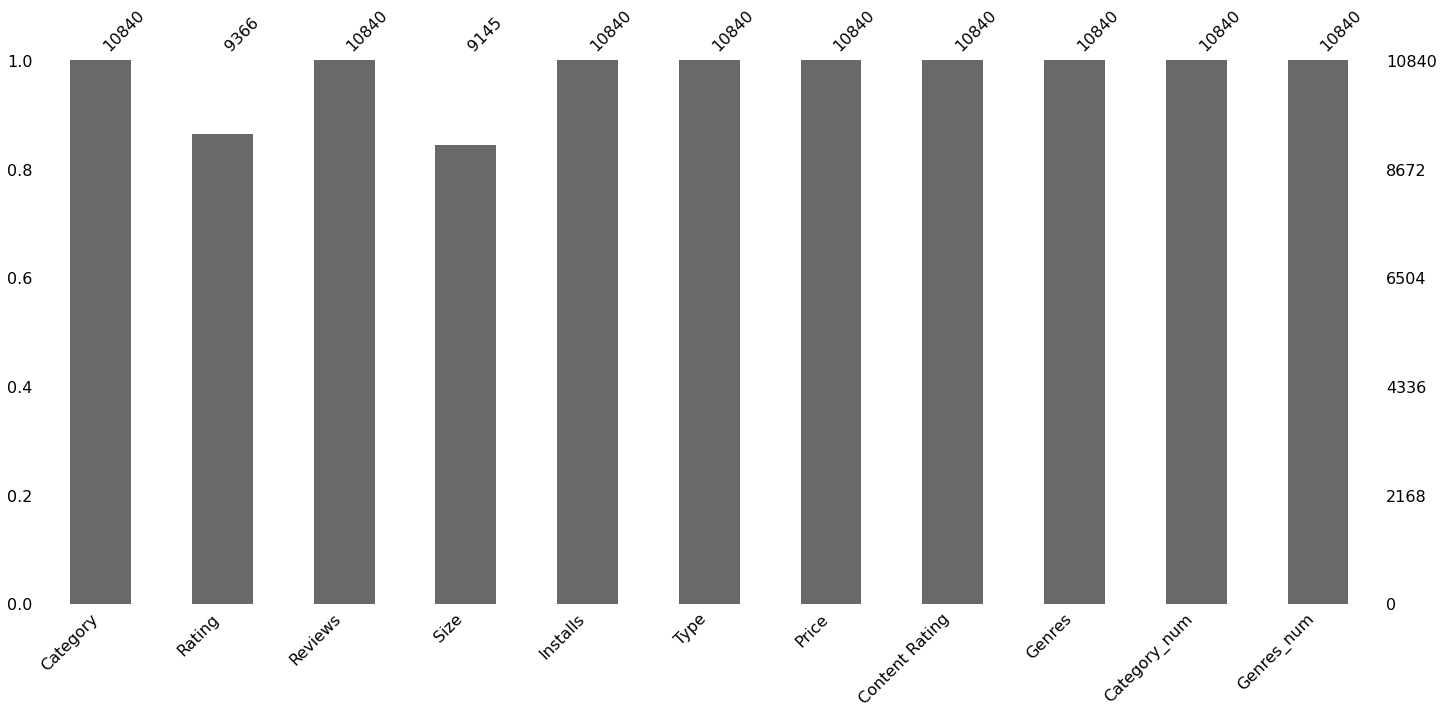

In [ ]:
msno.bar(data)

The bar chart above gives a quick graphical overview of the completeness of the dataset. We can see that Rating, Size columns have missing values.

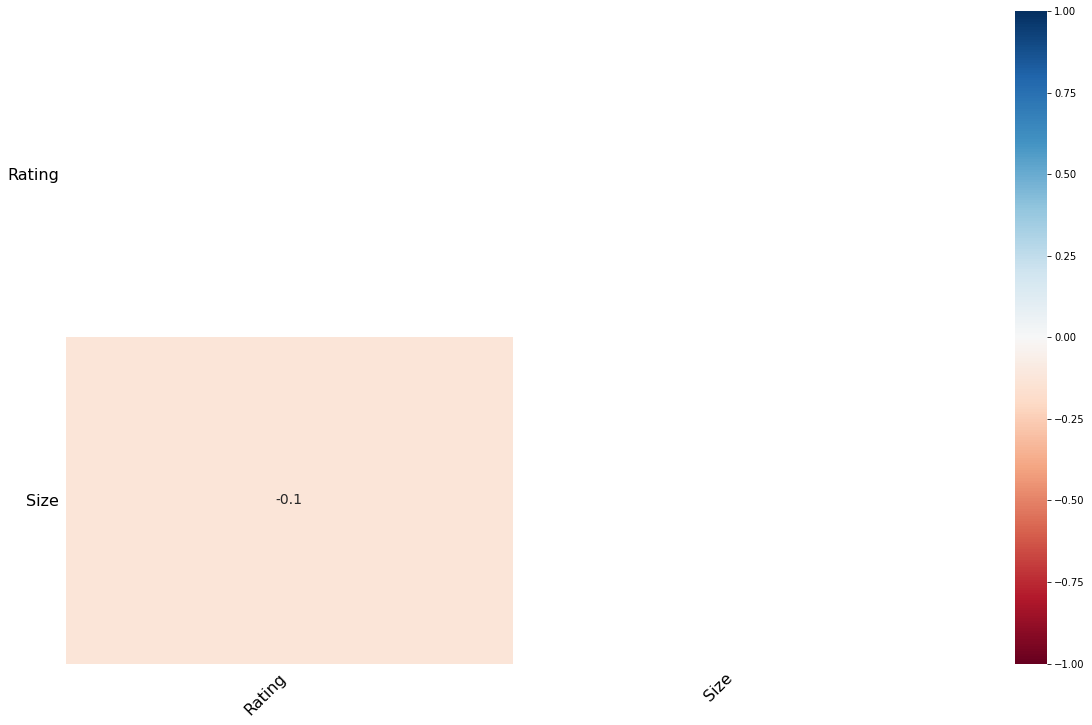

In [ ]:
msno.heatmap(data)

The heatmap function shows that there are no strong correlations between missing values of different features. This is good; low correlations further indicate that the data are MAR.

This dataset doesn't have much missing values but if I
 use the same methodology on datasets having a lot of missing values, some interesting pattern will definitely emerge.

In [ ]:
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_num,Genres_num
0,ART_AND_DESIGN,4.1,159.0,19000000.0,10000.0,0,0.0,1,Art & Design,0,9
1,ART_AND_DESIGN,3.9,967.0,14000000.0,500000.0,0,0.0,1,Art & Design;Pretend Play,0,12
2,ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000.0,0,0.0,1,Art & Design,0,9
3,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000.0,0,0.0,4,Art & Design,0,9
4,ART_AND_DESIGN,4.3,967.0,2800000.0,100000.0,0,0.0,1,Art & Design;Creativity,0,11


##Удалим строки, содержащие пропуски(baseline)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


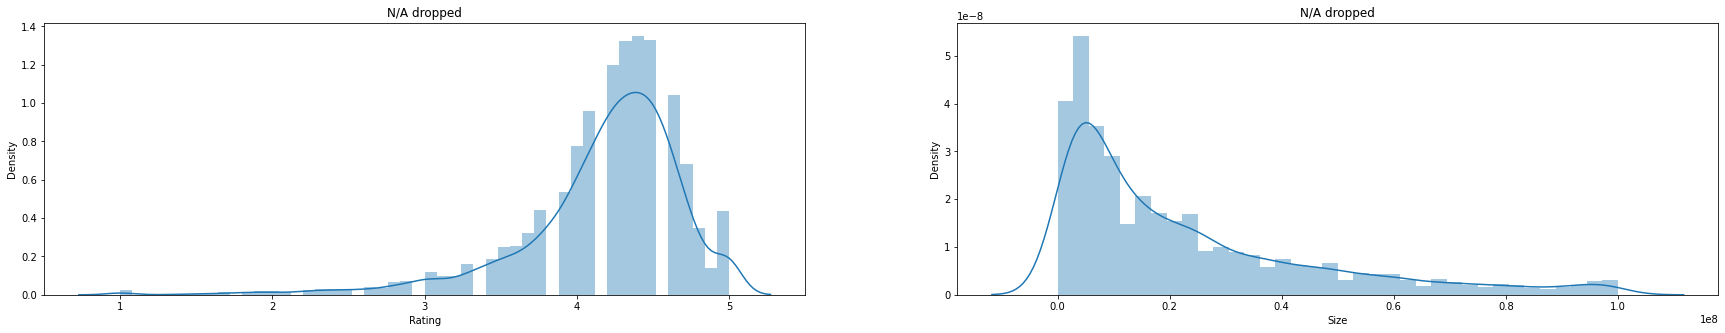

In [ ]:
#data.dropna(inplace=True)
new_df = data.copy()
new_df.dropna(inplace=True)

fig, ax =plt.subplots(1,2, figsize=(30,5))
ax[0].set_title('N/A dropped')
ax[1].set_title('N/A dropped')

sns.distplot(new_df["Rating"], ax=ax[0])
sns.distplot(new_df["Size"], ax=ax[1])

In [ ]:
new_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

In [ ]:
new_df.shape

(7729, 11)

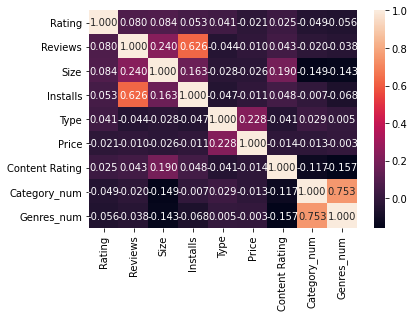

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt='.3f')

In [ ]:
X = new_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_dropna = new_df["Rating"]

In [ ]:
columns = X.columns
scaler = StandardScaler()
X_dropna = scaler.fit_transform(X)
pd.DataFrame(X_dropna, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,7.729000e+03,7.729000e+03,7.729000e+03,7.729000e+03,7.729000e+03,7.729000e+03
mean,-4.834961e-17,1.151090e-16,-1.970544e-15,-5.800481e-16,-2.682692e-16,5.913744e-16
std,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00
min,-1.581614e-01,-9.788915e-01,-1.679006e-01,-2.845681e-01,-1.458722e+00,-1.905039e+00
25%,-1.581040e-01,-7.531832e-01,-1.677012e-01,-2.845681e-01,-4.687788e-01,-7.646821e-01
50%,-1.569124e-01,-3.820857e-01,-1.659060e-01,-2.845681e-01,-4.687788e-01,1.055900e-01
75%,-1.372501e-01,4.283571e-01,-1.479546e-01,-2.845681e-01,-4.687788e-01,9.458528e-01
max,2.393809e+01,3.286234e+00,1.977816e+01,3.514097e+00,3.490993e+00,1.636069e+00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dropna, y_dropna,
                            test_size=0.2, random_state=88888888)

In [ ]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("mean_squared_error:",
          mean_squared_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

Для оперативности и простоты вычислений буду использовать линейную модель.
Также попробую оценить точность стратегий заполнению пропусков, использую модель Bagging, так как эта модель показала наилучшие результаты в разделе, где я выбирала лучшую модель для своего набора данных.

In [ ]:
lin_dropna = LinearRegression()
lin_dropna.fit(X_train, y_train)
test_model(lin_dropna)

mean_absolute_error: 0.3765516687987399
median_absolute_error: 0.2811199362573502
mean_squared_error: 0.29195164884255426
r2_score: 0.011048131198190148


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=241,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_dropna = gs.best_estimator_
b_gs_dropna.fit(X_train, y_train)
y_pred = b_gs_dropna.predict(X_test)
test_model(b_gs_dropna)

mean_absolute_error: 0.332454654764269
median_absolute_error: 0.22302904564314563
mean_squared_error: 0.2609314900204411
r2_score: 0.11612527037270359


##Заполним пропуски с помощью среднего значения

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


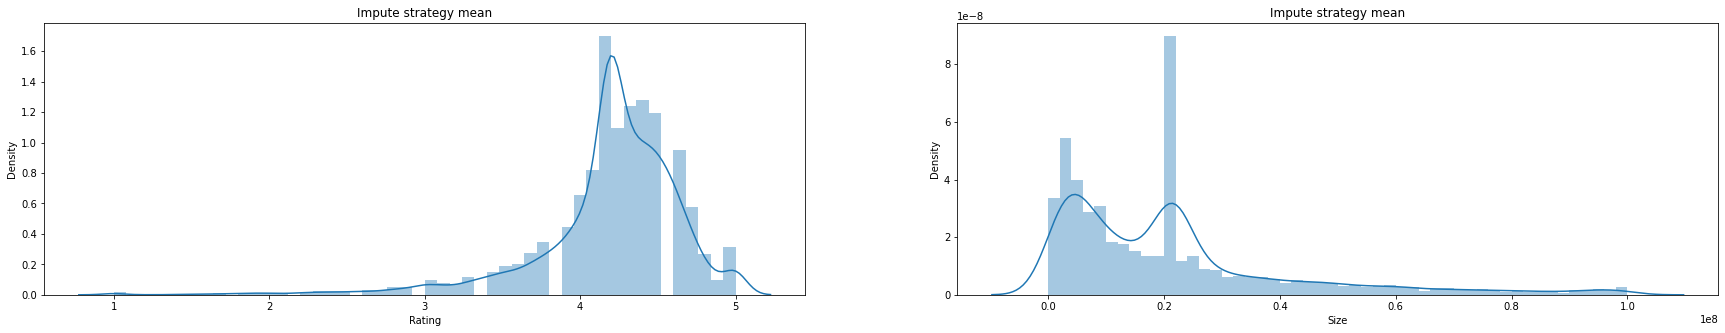

In [ ]:
mean_imp = SimpleImputer(strategy="mean")
new_df = data.copy()

new_df["Rating"] = mean_imp.fit_transform(new_df[["Rating"]])
new_df["Size"] = mean_imp.fit_transform(new_df[["Size"]])

fig, ax =plt.subplots(1,2, figsize=(30,5))
ax[0].set_title('Impute strategy mean')
ax[1].set_title('Impute strategy mean')

sns.distplot(new_df["Rating"], ax=ax[0])
sns.distplot(new_df["Size"], ax=ax[1])

In [ ]:
new_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

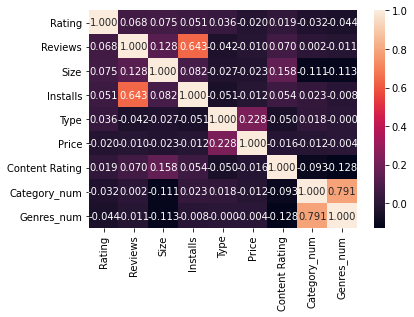

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt='.3f')

In [ ]:
X = new_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_mean = new_df["Rating"]

In [ ]:
columns = X.columns
scaler = StandardScaler()
X_mean = scaler.fit_transform(X)
pd.DataFrame(X_mean, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,8.623458e-16,1.651623e-16,-7.755993e-16,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-1.036705e+00,-1.818790e-01,-2.824692e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-7.527294e-01,-1.818672e-01,-2.824692e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-1.694996e-01,-1.807028e-01,-2.824692e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,2.161069e-01,-1.230730e-01,-2.824692e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.782967e+00,1.157931e+01,3.540210e+00,3.513515e+00,1.646057e+00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mean, y_mean,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_mean = LinearRegression()
lin_mean.fit(X_train, y_train)
test_model(lin_mean)

mean_absolute_error: 0.3040403927688181
median_absolute_error: 0.22052585425081794
mean_squared_error: 0.21164921777407997
r2_score: 0.012186492702961016


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=201,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_mean = gs.best_estimator_
b_gs_mean.fit(X_train, y_train)
y_pred = b_gs_mean.predict(X_test)
test_model(b_gs_mean)

mean_absolute_error: 0.27842796407755077
median_absolute_error: 0.1788940201830891
mean_squared_error: 0.18560723149339825
r2_score: 0.1337301774632833


##Заполним пропуски медианой

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


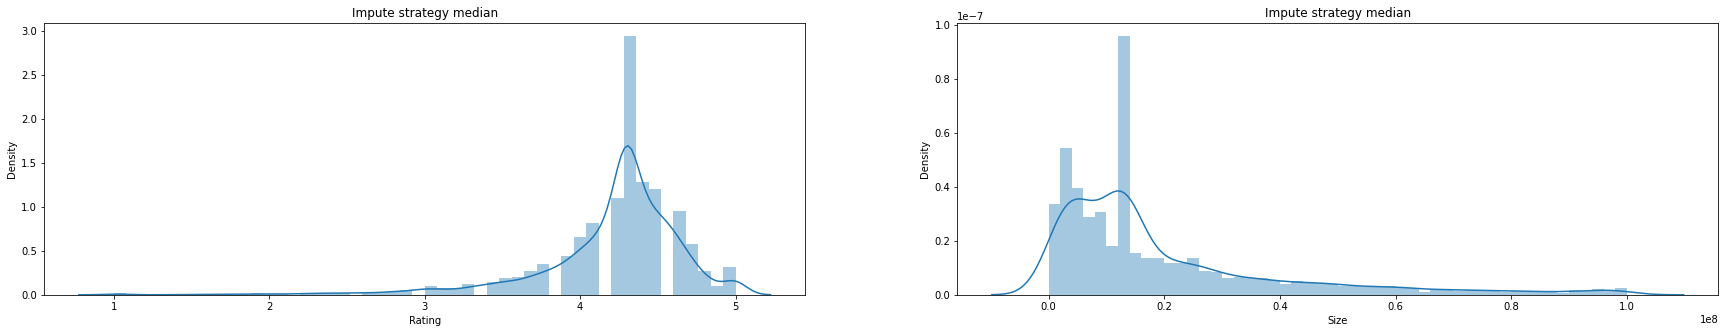

In [ ]:
med_imp = SimpleImputer(strategy="median")
new_df = data.copy()

new_df["Rating"] = med_imp.fit_transform(new_df[["Rating"]])
new_df["Size"] = med_imp.fit_transform(new_df[["Size"]])

fig, ax =plt.subplots(1,2, figsize=(30,5))
ax[0].set_title('Impute strategy median')
ax[1].set_title('Impute strategy median')

sns.distplot(new_df["Rating"], ax=ax[0])
sns.distplot(new_df["Size"], ax=ax[1])

In [ ]:
new_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

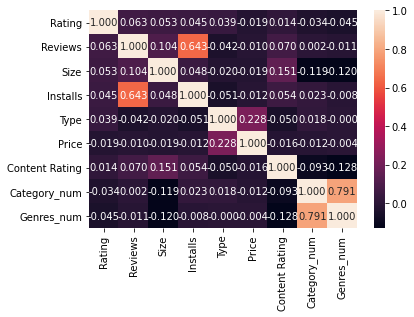

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt='.3f')

In [ ]:
X = new_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_median = new_df["Rating"]

In [ ]:
columns = X.columns
scaler = StandardScaler()
X_median = scaler.fit_transform(X)
pd.DataFrame(X_median, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,-3.476399e-16,1.651623e-16,-7.755993e-16,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-9.618837e-01,-1.818790e-01,-2.824692e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-6.810132e-01,-1.818672e-01,-2.824692e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-3.425289e-01,-1.807028e-01,-2.824692e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,2.772310e-01,-1.230730e-01,-2.824692e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.805096e+00,1.157931e+01,3.540210e+00,3.513515e+00,1.646057e+00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_median, y_median,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_median = LinearRegression()
lin_median.fit(X_train, y_train)
test_model(lin_median)

mean_absolute_error: 0.3118166345888924
median_absolute_error: 0.21165367827650927
mean_squared_error: 0.21333362533989417
r2_score: 0.009511937494780187


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=201,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_median = gs.best_estimator_
b_gs_median.fit(X_train, y_train)
y_pred = b_gs_median.predict(X_test)
test_model(b_gs_median)

mean_absolute_error: 0.2777116331997546
median_absolute_error: 0.17487562189054096
mean_squared_error: 0.1848957918573607
r2_score: 0.1415461376499737


##Заполним пропуски модой

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


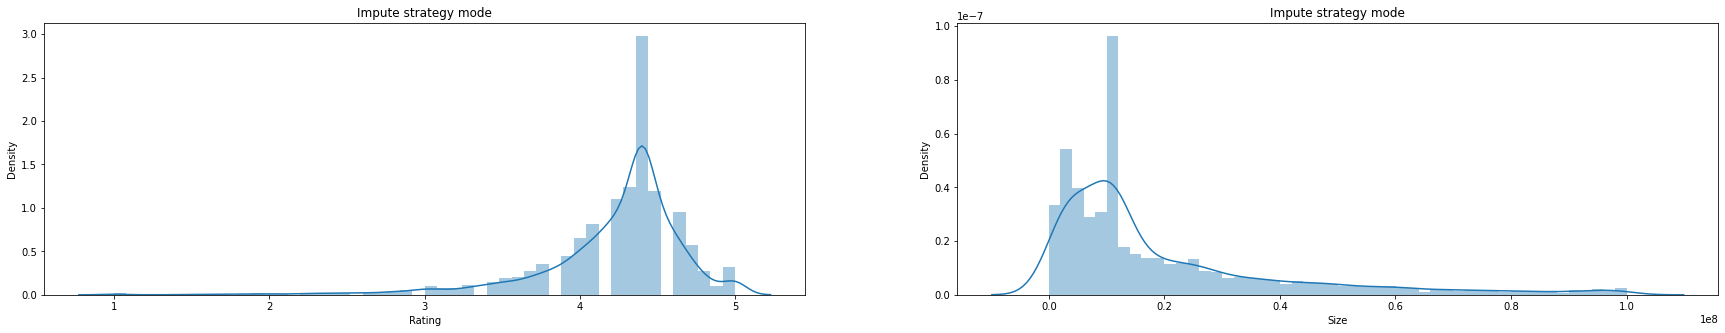

In [ ]:
mode_imp = SimpleImputer(strategy="most_frequent")
new_df = data.copy()

new_df["Rating"] = mode_imp.fit_transform(new_df[["Rating"]])
new_df["Size"] = mode_imp.fit_transform(new_df[["Size"]])

fig, ax =plt.subplots(1,2, figsize=(30,5))
ax[0].set_title('Impute strategy mode')
ax[1].set_title('Impute strategy mode')

sns.distplot(new_df["Rating"], ax=ax[0])
sns.distplot(new_df["Size"], ax=ax[1])

In [ ]:
new_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

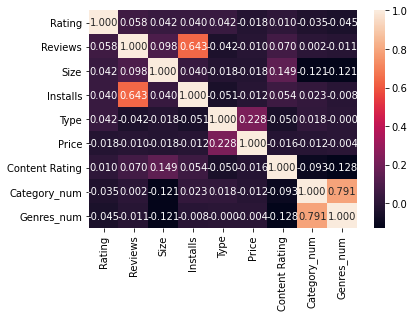

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt='.3f')

In [ ]:
X = new_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_mode = new_df["Rating"]

In [ ]:
columns = X.columns
scaler = StandardScaler()
X_mode = scaler.fit_transform(X)
pd.DataFrame(X_median, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,-3.476399e-16,1.651623e-16,-7.755993e-16,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-9.618837e-01,-1.818790e-01,-2.824692e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-6.810132e-01,-1.818672e-01,-2.824692e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-3.425289e-01,-1.807028e-01,-2.824692e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,2.772310e-01,-1.230730e-01,-2.824692e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.805096e+00,1.157931e+01,3.540210e+00,3.513515e+00,1.646057e+00


In [ ]:
lin_mode = LinearRegression()
lin_mode.fit(X_train, y_train)
test_model(lin_mode)

mean_absolute_error: 0.3118166345888924
median_absolute_error: 0.21165367827650927
mean_squared_error: 0.21333362533989417
r2_score: 0.009511937494780187


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=241,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_mode = gs.best_estimator_
b_gs_mode.fit(X_train, y_train)
y_pred = b_gs_mode.predict(X_test)
test_model(b_gs_mode)

mean_absolute_error: 0.27742036074406445
median_absolute_error: 0.17551867219917128
mean_squared_error: 0.1853273848550227
r2_score: 0.13954229174258825


##Заполним пропуски с помощью стратегии ffill

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


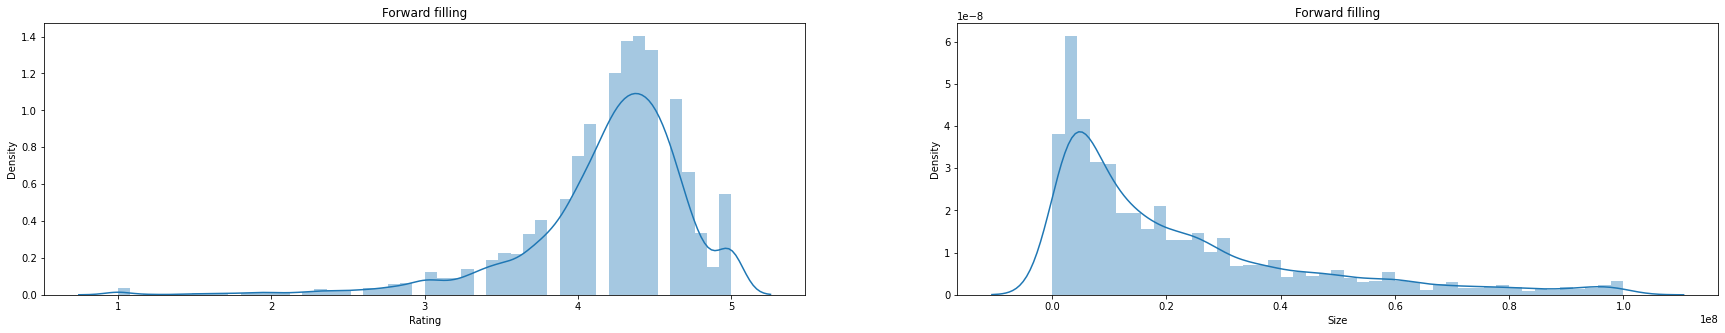

In [ ]:
new_df = data.copy()

new_df["Rating"] = new_df["Rating"].fillna(method='ffill')
new_df["Size"] = new_df["Size"].fillna(method='ffill')

fig, ax =plt.subplots(1,2, figsize=(30,5))
ax[0].set_title('Forward filling')
ax[1].set_title('Forward filling')

sns.distplot(new_df["Rating"], ax=ax[0])
sns.distplot(new_df["Size"], ax=ax[1])

In [ ]:
new_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

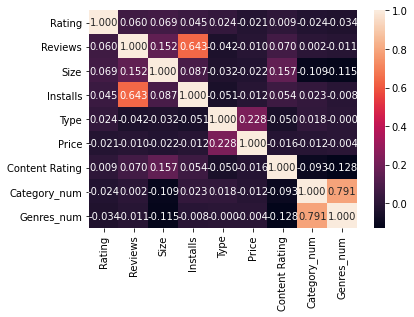

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt='.3f')

In [ ]:
X = new_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_ffill = new_df["Rating"]

In [ ]:
columns = X.columns
scaler = StandardScaler()
X_ffill = scaler.fit_transform(X)
pd.DataFrame(X_ffill, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,-2.138109e-15,1.651623e-16,-7.755993e-16,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-9.696086e-01,-1.818790e-01,-2.824692e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-7.435428e-01,-1.818672e-01,-2.824692e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-3.483772e-01,-1.807028e-01,-2.824692e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,3.620329e-01,-1.230730e-01,-2.824692e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.470077e+00,1.157931e+01,3.540210e+00,3.513515e+00,1.646057e+00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ffill, y_ffill,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_ffill = LinearRegression()
lin_ffill.fit(X_train, y_train)
test_model(lin_ffill)

mean_absolute_error: 0.3734320573735302
median_absolute_error: 0.2670938625955239
mean_squared_error: 0.28356129374436917
r2_score: 0.007743612030827962


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=181,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_ffill = gs.best_estimator_
b_gs_ffill.fit(X_train, y_train)
y_pred = b_gs_ffill.predict(X_test)
test_model(b_gs_ffill)

mean_absolute_error: 0.34489223999537943
median_absolute_error: 0.22265193370165615
mean_squared_error: 0.26587921995179936
r2_score: 0.06961789127937956


##Заполним пропуски с помощью 0

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


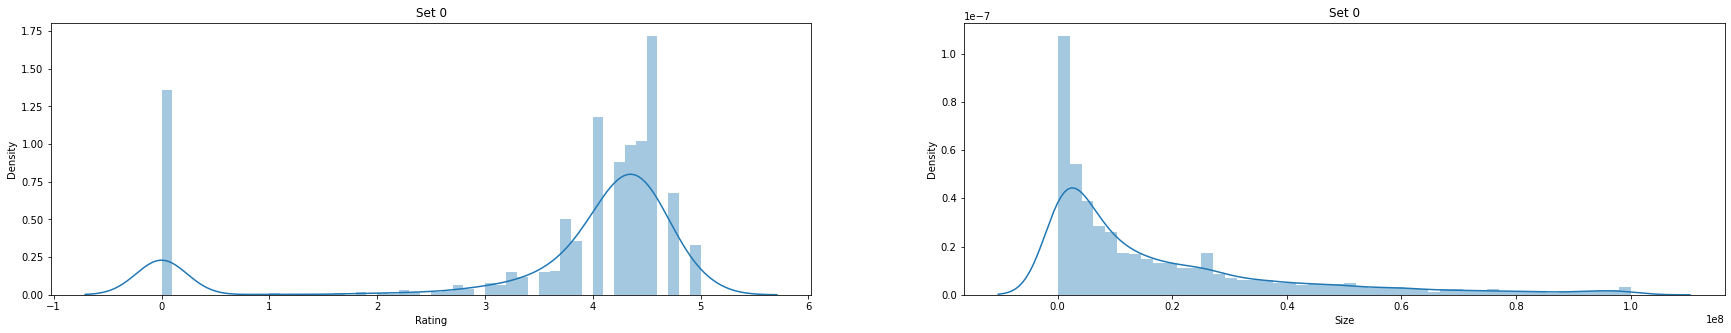

In [ ]:
new_df = data.copy()

new_df["Rating"] = new_df["Rating"].fillna(0)
new_df["Size"] = new_df["Size"].fillna(0)

fig, ax =plt.subplots(1,2, figsize=(30,5))
ax[0].set_title('Set 0')
ax[1].set_title('Set 0')

sns.distplot(new_df["Rating"], ax=ax[0])
sns.distplot(new_df["Size"], ax=ax[1])

In [ ]:
new_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

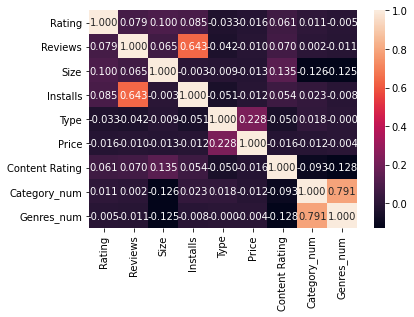

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt='.3f')

In [ ]:
X = new_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_zero = new_df["Rating"]

In [ ]:
columns = X.columns
scaler = StandardScaler()
X_zero = scaler.fit_transform(X)
pd.DataFrame(X_zero, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,-7.952555e-16,1.651623e-16,-7.755993e-16,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-8.187836e-01,-1.818790e-01,-2.824692e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-7.015058e-01,-1.818672e-01,-2.824692e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-4.038006e-01,-1.807028e-01,-2.824692e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,3.539944e-01,-1.230730e-01,-2.824692e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.691901e+00,1.157931e+01,3.540210e+00,3.513515e+00,1.646057e+00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_zero, y_zero,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_zero = LinearRegression()
lin_zero.fit(X_train, y_train)
test_model(lin_zero)

mean_absolute_error: 1.089918577393945
median_absolute_error: 0.7535882772690956
mean_squared_error: 2.305299923871087
r2_score: 0.0189447503597443


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=171,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_zero = gs.best_estimator_
b_gs_zero.fit(X_train, y_train)
y_pred = b_gs_zero.predict(X_test)
test_model(b_gs_zero)

mean_absolute_error: 0.551489140332848
median_absolute_error: 0.22543859649122422
mean_squared_error: 1.0012551967966508
r2_score: 0.5739007072895425


##Заполним пропуски с помощью K Means

In [ ]:
#Удалим признаки, содержащие пропуски
new_df = data.copy()

new_df = new_df.drop(["Rating", "Size", "Category", "Genres"], axis=1)
new_df.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num
0,159.0,10000.0,0,0.0,1,0,9
1,967.0,500000.0,0,0.0,1,0,12
2,87510.0,5000000.0,0,0.0,1,0,9
3,215644.0,50000000.0,0,0.0,4,0,9
4,967.0,100000.0,0,0.0,1,0,11


In [ ]:
#нормализуем данные для кластеризации
columns = new_df.columns
scaler = StandardScaler()
scaled_df = scaler.fit_transform(new_df)
pd.DataFrame(scaled_df, columns=columns).describe()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,1.651623e-16,-7.755993e-16,-1.986603e-15,4.811086e-16,2.680295e-15,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-1.818790e-01,-2.824692e-01,-6.441596e-02,-1.456148e+00,-2.002337e+00,-1.968561e+00
25%,-1.516980e-01,-1.818672e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,-6.854329e-01,-8.045318e-01
50%,-1.509957e-01,-1.807028e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,-3.262772e-01,8.380663e-02
75%,-1.330011e-01,-1.230730e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,9.906268e-01,9.721450e-01
max,2.654511e+01,1.157931e+01,3.540210e+00,2.501558e+01,3.513515e+00,1.828657e+00,1.646057e+00


In [ ]:
#на оставшихся признаках надо обучить алгоритм кластеризации
from sklearn.cluster import KMeans

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
#notice that SSE continues to decrease as you increase k
#As more centroids are added, the distance from each point to its closest centroid will decrease
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_df)
  sse.append(kmeans.inertia_)

<function matplotlib.pyplot.show>

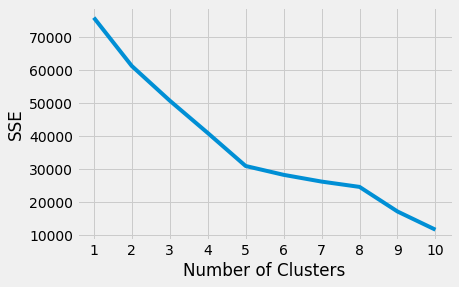

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show
#по правилу локтя выберу точку х=5

In [ ]:
!pip install kneed

In [ ]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

5

In [ ]:
kmeans = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300, random_state=42)
kmeans.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [ ]:
# assign a cluster to each example
yhat = kmeans.predict(scaled_df)

In [ ]:
print(np.unique(kmeans.labels_))

[0 1 2 3 4]


In [ ]:
kmeans_df = pd.DataFrame(scaled_df, columns=columns)
kmeans_df.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num
0,-0.151657,-0.181761,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870
1,-0.151381,-0.175998,-0.282469,-0.064416,-0.462215,-2.002337,-1.600973
2,-0.121820,-0.123073,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870
4,-0.151381,-0.180703,-0.282469,-0.064416,-0.462215,-2.002337,-1.631605


In [ ]:
kmeans_df['Cluster ID'] = kmeans.labels_
kmeans_df.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Cluster ID
0,-0.151657,-0.181761,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,4
1,-0.151381,-0.175998,-0.282469,-0.064416,-0.462215,-2.002337,-1.600973,4
2,-0.121820,-0.123073,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,4
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1
4,-0.151381,-0.180703,-0.282469,-0.064416,-0.462215,-2.002337,-1.631605,4


In [ ]:
print(np.unique(kmeans_df['Cluster ID']))

[0 1 2 3 4]


In [ ]:
data.isnull().sum()

Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Category_num         0
Genres_num           0
dtype: int64

In [ ]:
scaler = StandardScaler()
rating = scaler.fit_transform(data['Rating'].values.reshape(-1,1))
size = scaler.fit_transform(data['Size'].values.reshape(-1,1))

In [ ]:
frame = {'Rating': pd.Series(rating.reshape(-1)), 'Size': pd.Series(size.reshape(-1))}
rating_size_df = pd.DataFrame(frame)
rating_size_df.isnull().sum()

Rating    1474
Size      1695
dtype: int64

полученные rating и size мы отмасштабировали и теперь надо добавить эти колонки в набор данных с метками кластеров, сгруппировать по меткам и для каждой группы отдельно заполнить пропуски 

In [ ]:
kmeans_df['Rating'] = rating
kmeans_df['Size'] = size
kmeans_df.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Cluster ID,Rating,Size
0,-0.151657,-0.181761,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,4,-0.178104,-0.111412
1,-0.151381,-0.175998,-0.282469,-0.064416,-0.462215,-2.002337,-1.600973,4,-0.566309,-0.332774
2,-0.121820,-0.123073,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,4,0.986512,-0.567417
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.598307,0.154221
4,-0.151381,-0.180703,-0.282469,-0.064416,-0.462215,-2.002337,-1.631605,4,0.210102,-0.828623


In [ ]:
#получим среднее для каждой переменной и выберем среднее для rating и size
kmeans_df.groupby(by=["Cluster ID"]).mean()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Rating,Size
Cluster ID,,,,,,,,,
0,6.156666,8.248618,-0.282469,-0.064416,0.381375,-0.013399,-0.094067,0.252511,1.534710
1,-0.020092,-0.070629,-0.282469,-0.064416,2.264577,-0.310566,-0.369588,0.003841,0.325875
2,-0.068510,-0.072667,-0.282469,-0.064416,-0.383000,0.817821,0.808099,-0.071732,-0.129350
3,-0.147729,-0.180808,3.540210,0.807331,-0.176816,0.063518,-0.001207,0.145301,-0.097800
4,-0.070696,-0.103346,-0.282469,-0.064416,-0.418912,-0.843021,-0.792671,0.045389,0.022186


Заполним признак Rating & Size

In [ ]:
rslt_df_0 = kmeans_df[kmeans_df['Cluster ID'] == 0]
rslt_df_0['Rating'].fillna((rslt_df_0['Rating'].mean()), inplace=True)
rslt_df_0['Size'].fillna((rslt_df_0['Size'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
rslt_df_1 = kmeans_df[kmeans_df['Cluster ID'] == 1]
print(rslt_df_1['Rating'].mean())

0.003841142332314502


In [ ]:
mean_val = rslt_df_1['Rating'].mean()
rslt_df_1['Rating'].fillna(mean_val, inplace=True)
rslt_df_1['Size'].fillna((rslt_df_1['Size'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
rslt_df_1.isnull().sum()

Reviews           0
Installs          0
Type              0
Price             0
Content Rating    0
Category_num      0
Genres_num        0
Cluster ID        0
Rating            0
Size              0
dtype: int64

In [ ]:
rslt_df_1.head(10)

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Cluster ID,Rating,Size
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.598307,0.154221
12,-0.136399,-0.064267,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.015999,-0.067140
34,-0.151590,-0.181761,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.986512,-0.766642
72,-0.058830,-0.064267,-0.282469,-0.064416,2.519582,-1.882618,-1.570341,1,0.015999,-0.244229
112,-0.151647,-0.181291,-0.282469,-0.064416,2.519582,-1.762900,-1.539708,1,-0.178104,0.375582
126,-0.151488,-0.180703,-0.282469,-0.064416,2.519582,-1.762900,-1.539708,1,0.003841,-0.624971
129,-0.151685,-0.181761,-0.282469,-0.064416,1.525650,-1.762900,-1.539708,1,0.003841,-0.824196
133,-0.151549,-0.180703,-0.282469,-0.064416,1.525650,-1.762900,-1.539708,1,0.598307,-0.589553
134,-0.151701,-0.181761,-0.282469,-0.064416,1.525650,-1.762900,-1.539708,1,0.003841,-0.514290
139,0.843882,0.994240,-0.282469,-0.064416,2.519582,-1.643181,-1.386547,1,0.792410,0.325875


In [ ]:
rslt_df_2 = kmeans_df[kmeans_df['Cluster ID'] == 2]
rslt_df_2['Rating'].fillna((rslt_df_2['Rating'].mean()), inplace=True)
rslt_df_2['Size'].fillna((rslt_df_2['Size'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
rslt_df_3 = kmeans_df[kmeans_df['Cluster ID'] == 3]
rslt_df_3['Rating'].fillna((rslt_df_3['Rating'].mean()), inplace=True)
rslt_df_3['Size'].fillna((rslt_df_3['Size'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
rslt_df_4 = kmeans_df[kmeans_df['Cluster ID'] == 4]
rslt_df_4['Rating'].fillna((rslt_df_4['Rating'].mean()), inplace=True)
rslt_df_4['Size'].fillna((rslt_df_4['Size'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
frames = [rslt_df_0, rslt_df_1, rslt_df_2, rslt_df_3, rslt_df_4]
res = pd.concat(frames)
res.sort_index(inplace=True)
res.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Cluster ID,Rating,Size
0,-0.151657,-0.181761,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,4,-0.178104,-0.111412
1,-0.151381,-0.175998,-0.282469,-0.064416,-0.462215,-2.002337,-1.600973,4,-0.566309,-0.332774
2,-0.121820,-0.123073,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,4,0.986512,-0.567417
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.598307,0.154221
4,-0.151381,-0.180703,-0.282469,-0.064416,-0.462215,-2.002337,-1.631605,4,0.210102,-0.828623


In [ ]:
res.isnull().sum()

Reviews           0
Installs          0
Type              0
Price             0
Content Rating    0
Category_num      0
Genres_num        0
Cluster ID        0
Rating            0
Size              0
dtype: int64

In [ ]:
res.shape

(10840, 10)

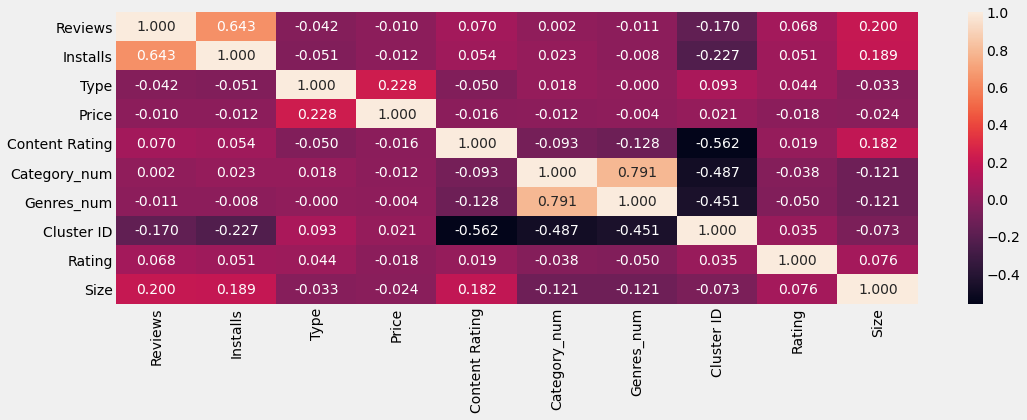

In [ ]:
plt.figure(figsize = (16,5))
sns.heatmap(res.corr(), annot=True, fmt='.3f')

In [ ]:
X_clust = res.drop(["Rating", "Price", "Category_num", "Cluster ID"], axis=1)
y_clust = res["Rating"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clust, y_clust,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_clust = LinearRegression()
lin_clust.fit(X_train, y_train)
test_model(lin_clust)

mean_absolute_error: 0.5890693937957163
median_absolute_error: 0.43110099852952566
mean_squared_error: 0.7975959369342022
r2_score: 0.012799176859613182


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=191,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_clust = gs.best_estimator_
b_gs_clust.fit(X_train, y_train)
y_pred = b_gs_clust.predict(X_test)
test_model(b_gs_clust)

mean_absolute_error: 0.5389721674052373
median_absolute_error: 0.34243842605463704
mean_squared_error: 0.6986716989737252
r2_score: 0.13523973180839632


##заполним пропуски с помощью GMM кластеризации

In [ ]:
#Удалим признаки, содержащие пропуски
new_df = data.copy()

new_df = new_df.drop(["Rating", "Size", "Category", "Genres"], axis=1)
new_df.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num
0,159.0,10000.0,0,0.0,1,0,9
1,967.0,500000.0,0,0.0,1,0,12
2,87510.0,5000000.0,0,0.0,1,0,9
3,215644.0,50000000.0,0,0.0,4,0,9
4,967.0,100000.0,0,0.0,1,0,11


In [ ]:
#нормализуем данные для кластеризации
columns = new_df.columns
scaler = StandardScaler()
scaled_df = scaler.fit_transform(new_df)
pd.DataFrame(scaled_df, columns=columns).describe()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,1.651623e-16,-7.755993e-16,-1.986603e-15,4.811086e-16,2.680295e-15,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-1.818790e-01,-2.824692e-01,-6.441596e-02,-1.456148e+00,-2.002337e+00,-1.968561e+00
25%,-1.516980e-01,-1.818672e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,-6.854329e-01,-8.045318e-01
50%,-1.509957e-01,-1.807028e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,-3.262772e-01,8.380663e-02
75%,-1.330011e-01,-1.230730e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,9.906268e-01,9.721450e-01
max,2.654511e+01,1.157931e+01,3.540210e+00,2.501558e+01,3.513515e+00,1.828657e+00,1.646057e+00


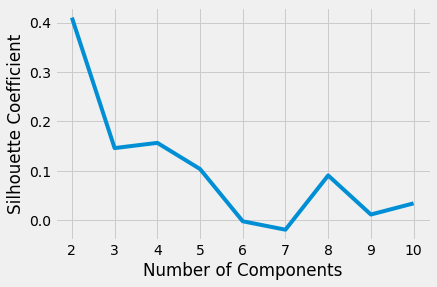

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

gmm_kwargs = {
    "init_params": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
  gmm = GaussianMixture(n_components=k, **gmm_kwargs)
  gmm.fit(scaled_df)
  cluster_labels=gmm.predict(scaled_df)
  score = silhouette_score(scaled_df, cluster_labels)
  silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Components")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
gmm = GaussianMixture(n_components=4, n_init=10, max_iter=300, random_state=42)
gmm.fit(scaled_df)
# assign a cluster to each example
yhat = gmm.predict(scaled_df)

In [ ]:
print(np.unique(yhat))

[0 1 2 3]


In [ ]:
gmm_df = pd.DataFrame(scaled_df, columns=columns)
gmm_df['Cluster ID'] = yhat
gmm_df.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Cluster ID
0,-0.151657,-0.181761,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,3
1,-0.151381,-0.175998,-0.282469,-0.064416,-0.462215,-2.002337,-1.600973,3
2,-0.121820,-0.123073,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,1
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,0
4,-0.151381,-0.180703,-0.282469,-0.064416,-0.462215,-2.002337,-1.631605,3


In [ ]:
scaler = StandardScaler()
rating = scaler.fit_transform(data['Rating'].values.reshape(-1,1))
size = scaler.fit_transform(data['Size'].values.reshape(-1,1))

frame = {'Rating': pd.Series(rating.reshape(-1)), 'Size': pd.Series(size.reshape(-1))}
rating_size_df = pd.DataFrame(frame)
rating_size_df.isnull().sum()

Rating    1474
Size      1695
dtype: int64

In [ ]:
gmm_df['Rating'] = rating
gmm_df['Size'] = size
gmm_df.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Cluster ID,Rating,Size
0,-0.151657,-0.181761,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,3,-0.178104,-0.111412
1,-0.151381,-0.175998,-0.282469,-0.064416,-0.462215,-2.002337,-1.600973,3,-0.566309,-0.332774
2,-0.121820,-0.123073,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870,1,0.986512,-0.567417
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,0,0.598307,0.154221
4,-0.151381,-0.180703,-0.282469,-0.064416,-0.462215,-2.002337,-1.631605,3,0.210102,-0.828623


In [ ]:
temp_df_0 = gmm_df[gmm_df['Cluster ID'] == 0]
temp_df_0['Rating'].fillna((temp_df_0['Rating'].mean()), inplace=True)
temp_df_0['Size'].fillna((temp_df_0['Size'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
temp_df_0.isnull().sum()

Reviews           0
Installs          0
Type              0
Price             0
Content Rating    0
Category_num      0
Genres_num        0
Cluster ID        0
Rating            0
Size              0
dtype: int64

In [ ]:
temp_df_1 = gmm_df[gmm_df['Cluster ID'] == 1]
temp_df_1['Rating'].fillna((temp_df_1['Rating'].mean()), inplace=True)
temp_df_1['Size'].fillna((temp_df_1['Size'].mean()), inplace=True)

temp_df_2 = gmm_df[gmm_df['Cluster ID'] == 2]
temp_df_2['Rating'].fillna((temp_df_2['Rating'].mean()), inplace=True)
temp_df_2['Size'].fillna((temp_df_2['Size'].mean()), inplace=True)

temp_df_3 = gmm_df[gmm_df['Cluster ID'] == 3]
temp_df_3['Rating'].fillna((temp_df_3['Rating'].mean()), inplace=True)
temp_df_3['Size'].fillna((temp_df_3['Size'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
frames = [rslt_df_0, rslt_df_1, rslt_df_2, rslt_df_3]
res = pd.concat(frames)
res.sort_index(inplace=True)
res.head()

,Reviews,Installs,Type,Price,Content Rating,Category_num,Genres_num,Cluster ID,Rating,Size
3,-0.078053,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.598307,0.154221
12,-0.136399,-0.064267,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.015999,-0.067140
34,-0.151590,-0.181761,-0.282469,-0.064416,2.519582,-2.002337,-1.692870,1,0.986512,-0.766642
72,-0.058830,-0.064267,-0.282469,-0.064416,2.519582,-1.882618,-1.570341,1,0.015999,-0.244229
112,-0.151647,-0.181291,-0.282469,-0.064416,2.519582,-1.762900,-1.539708,1,-0.178104,0.375582


In [ ]:
res.isnull().sum()

Reviews           0
Installs          0
Type              0
Price             0
Content Rating    0
Category_num      0
Genres_num        0
Cluster ID        0
Rating            0
Size              0
dtype: int64

In [ ]:
X_clust_gmm = res.drop(["Rating", "Genres_num", "Category_num", "Cluster ID"], axis=1)
y_clust_gmm = res["Rating"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clust_gmm, y_clust_gmm,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_clust_gmm = LinearRegression()
lin_clust_gmm.fit(X_train, y_train)
test_model(lin_clust_gmm)

mean_absolute_error: 0.6135477363576429
median_absolute_error: 0.4431597013965141
mean_squared_error: 0.85813734819527
r2_score: 0.01622358588113071


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=131,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_clust_gmm = gs.best_estimator_
b_gs_clust_gmm.fit(X_train, y_train)
y_pred = b_gs_clust_gmm.predict(X_test)
test_model(b_gs_clust_gmm)

mean_absolute_error: 0.5625965274457387
median_absolute_error: 0.3290301011294392
mean_squared_error: 0.8002212867501205
r2_score: 0.08261908232260728


##заполним пропуски с помощью регрессии

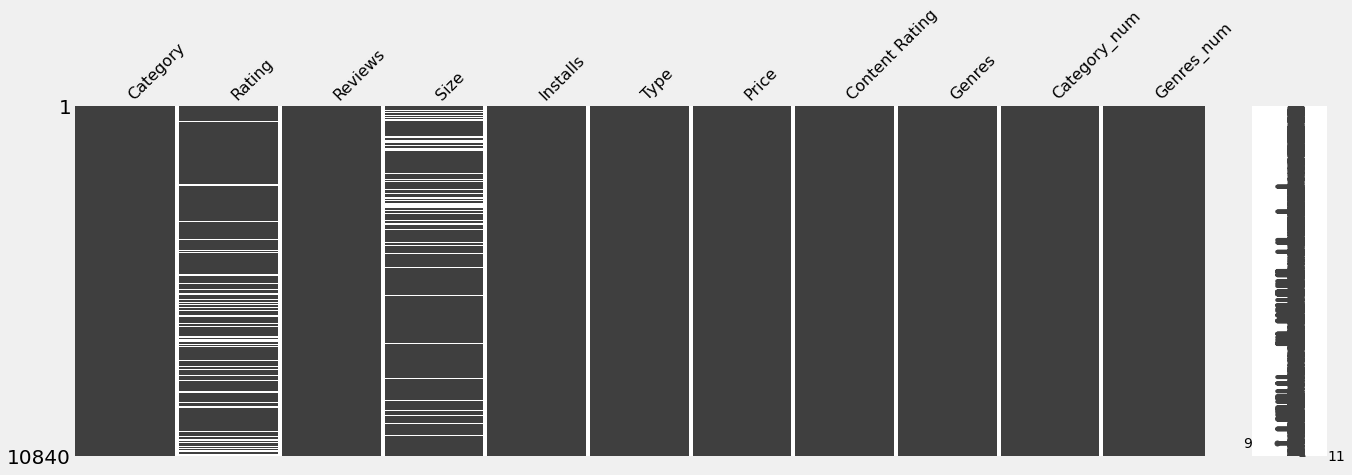

In [ ]:
import missingno as mno

mno.matrix(data, figsize = (20, 6))

Visualizing the locations of the missing data
The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
The plot appears blank(white) wherever there are missing values. For instance, in Size column a lot of instances of missing data.
Both the Rating and Size columns have a lot of missing values.This could be a case of MAR as we cannot directly observe the reason for missingness of data in these columns.

In [ ]:
new_df = data.copy()

missing_columns = ["Rating", "Size"]
#data = data.drop(['Category', 'Genres'], axis=1)

In [ ]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

for feature in missing_columns:
    new_df[feature + '_imp'] = new_df[feature]
    df = random_imputation(new_df, feature)

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_num,Genres_num,Rating_imp,Size_imp
0,ART_AND_DESIGN,4.1,159.0,19000000.0,10000.0,0,0.0,1,Art & Design,0,9,4.1,19000000.0
1,ART_AND_DESIGN,3.9,967.0,14000000.0,500000.0,0,0.0,1,Art & Design;Pretend Play,0,12,3.9,14000000.0
2,ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000.0,0,0.0,1,Art & Design,0,9,4.7,8700000.0
3,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000.0,0,0.0,4,Art & Design,0,9,4.5,25000000.0
4,ART_AND_DESIGN,4.3,967.0,2800000.0,100000.0,0,0.0,1,Art & Design;Creativity,0,11,4.3,2800000.0


In [ ]:
df = df.drop(['Category', 'Genres'], axis=1)

In [ ]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = df[feature + "_imp"]
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    #to preserve the index of the missing data from the original dataframe
    deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

In [ ]:
deter_data.isnull().sum()

DetRating    0
DetSize      0
dtype: int64

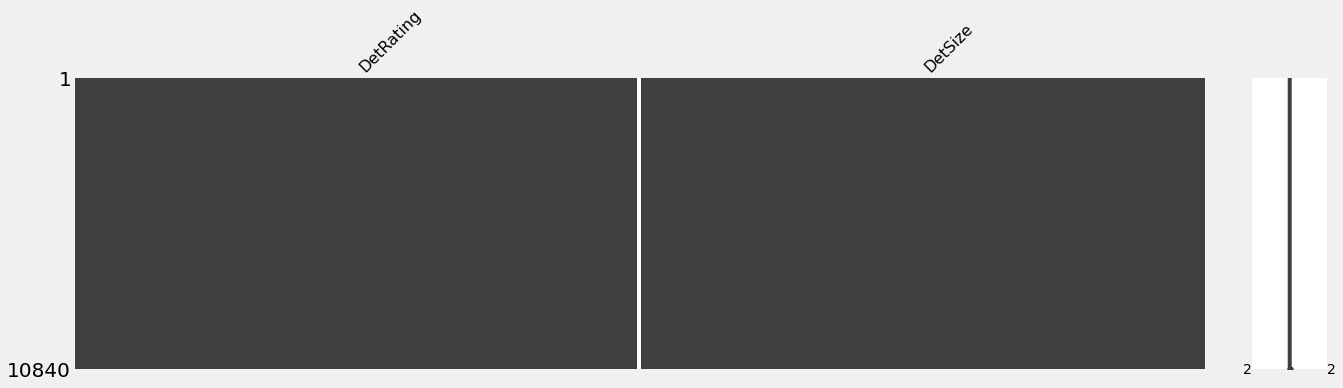

In [ ]:
mno.matrix(deter_data, figsize = (20,5))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


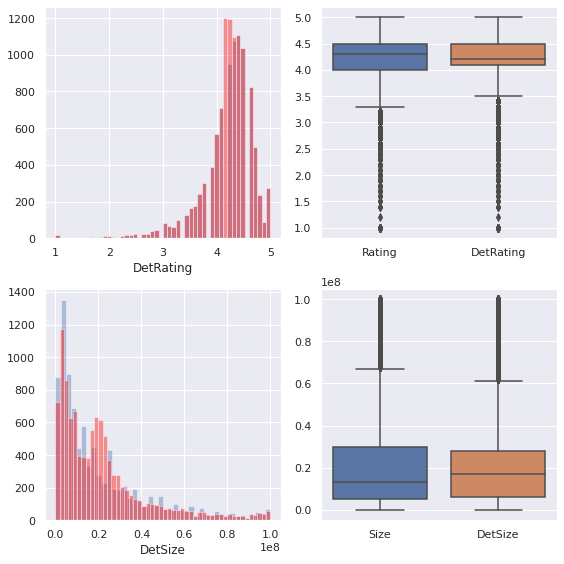

In [ ]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Rating", "Size"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')
    
    sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])
    
plt.tight_layout()

In [ ]:
pd.concat([df[["Rating", "Size"]], deter_data[["DetRating", "DetSize"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,9366.0,4.191757e+00,5.152189e-01,1.0,4.0,4.3,4.5,5.0
Size,9145.0,2.151653e+07,2.258875e+07,8500.0,4900000.0,13000000.0,30000000.0,100000000.0
DetRating,10840.0,4.190188e+00,4.791031e-01,1.0,4.1,4.2,4.5,5.0
DetSize,10840.0,2.165778e+07,2.092104e+07,8500.0,5900000.0,17000000.0,28000000.0,100000000.0


In [ ]:
df['Rating'] = deter_data["DetRating"]
df['Size'] = deter_data["DetSize"]

df.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Category_num,Genres_num,Rating_imp,Size_imp
0,4.1,159.0,19000000.0,10000.0,0,0.0,1,0,9,4.1,19000000.0
1,3.9,967.0,14000000.0,500000.0,0,0.0,1,0,12,3.9,14000000.0
2,4.7,87510.0,8700000.0,5000000.0,0,0.0,1,0,9,4.7,8700000.0
3,4.5,215644.0,25000000.0,50000000.0,0,0.0,4,0,9,4.5,25000000.0
4,4.3,967.0,2800000.0,100000.0,0,0.0,1,0,11,4.3,2800000.0


In [ ]:
df = df.drop(['Rating_imp', 'Size_imp'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rating          10840 non-null  float64
 1   Reviews         10840 non-null  float64
 2   Size            10840 non-null  float64
 3   Installs        10840 non-null  float64
 4   Type            10840 non-null  int64  
 5   Price           10840 non-null  float64
 6   Content Rating  10840 non-null  int64  
 7   Category_num    10840 non-null  int64  
 8   Genres_num      10840 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 846.9 KB


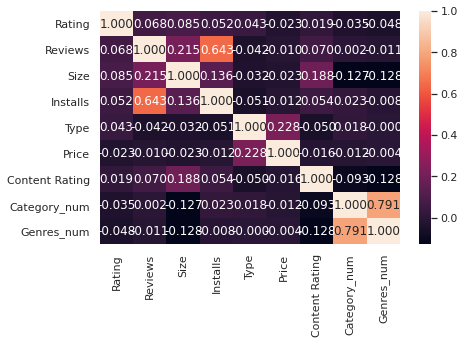

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt='.3f')

In [ ]:
X_regr = df.drop(["Rating", "Price", "Category_num"], axis=1)
y_regr = df["Rating"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_regr, y_regr,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
test_model(lin_regr)

mean_absolute_error: 0.3014627041143159
median_absolute_error: 0.2219468797337878
mean_squared_error: 0.21150858482392515
r2_score: 0.013790129954741492


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=201,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_regr = gs.best_estimator_
b_gs_regr.fit(X_train, y_train)
y_pred = b_gs_regr.predict(X_test)
test_model(b_gs_regr)

mean_absolute_error: 0.2759051209008961
median_absolute_error: 0.17267261734089345
mean_squared_error: 0.1853635302444975
r2_score: 0.13569776269016154


## заполним пропуски с помощью KNN

In [ ]:
new_df = data.copy()

new_df = new_df.drop(['Category', 'Genres'], axis=1)
new_df.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Category_num,Genres_num
0,4.1,159.0,19000000.0,10000.0,0,0.0,1,0,9
1,3.9,967.0,14000000.0,500000.0,0,0.0,1,0,12
2,4.7,87510.0,8700000.0,5000000.0,0,0.0,1,0,9
3,4.5,215644.0,25000000.0,50000000.0,0,0.0,4,0,9
4,4.3,967.0,2800000.0,100000.0,0,0.0,1,0,11


In [ ]:
new_df.isnull().sum()

Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 0
Price                0
Content Rating       0
Category_num         0
Genres_num           0
dtype: int64

In [ ]:
#нормализуем данные
columns = new_df.columns
scaler = StandardScaler()
scaled_df = scaler.fit_transform(new_df)
pd.DataFrame(scaled_df, columns=columns).describe()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Category_num,Genres_num
count,9.366000e+03,1.084000e+04,9.145000e+03,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,6.371300e-15,-1.296690e-16,-2.510036e-16,1.651623e-16,-7.755993e-16,-1.986603e-15,4.811086e-16,2.680295e-15,-8.467645e-15
std,1.000053e+00,1.000046e+00,1.000055e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-6.195285e+00,-1.517110e-01,-9.522088e-01,-1.818790e-01,-2.824692e-01,-6.441596e-02,-1.456148e+00,-2.002337e+00,-1.968561e+00
25%,-3.722062e-01,-1.516980e-01,-7.356511e-01,-1.818672e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,-6.854329e-01,-8.045318e-01
50%,2.101017e-01,-1.509957e-01,-3.770459e-01,-1.807028e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,-3.262772e-01,8.380663e-02
75%,5.983070e-01,-1.330011e-01,3.755823e-01,-1.230730e-01,-2.824692e-01,-6.441596e-02,-4.622153e-01,9.906268e-01,9.721450e-01
max,1.568820e+00,2.654511e+01,3.474640e+00,1.157931e+01,3.540210e+00,2.501558e+01,3.513515e+00,1.828657e+00,1.646057e+00


In [ ]:
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=21)
# fit on the dataset
imputer.fit(scaled_df)
# transform the dataset
Xtrans = imputer.transform(scaled_df)

In [ ]:
df = pd.DataFrame(Xtrans, columns=['Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Category_num', 'Genres_num'])
df.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Category_num,Genres_num
0,-0.178104,-0.151657,-0.111412,-0.181761,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870
1,-0.566309,-0.151381,-0.332774,-0.175998,-0.282469,-0.064416,-0.462215,-2.002337,-1.600973
2,0.986512,-0.121820,-0.567417,-0.123073,-0.282469,-0.064416,-0.462215,-2.002337,-1.692870
3,0.598307,-0.078053,0.154221,0.406180,-0.282469,-0.064416,2.519582,-2.002337,-1.692870
4,0.210102,-0.151381,-0.828623,-0.180703,-0.282469,-0.064416,-0.462215,-2.002337,-1.631605


In [ ]:
df.isnull().sum()

Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Category_num      0
Genres_num        0
dtype: int64

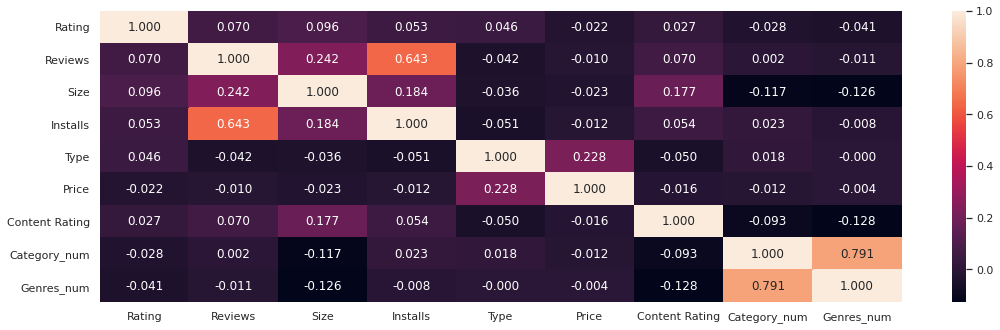

In [ ]:
plt.figure(figsize = (16,5))
sns.heatmap(df.corr(), annot=True, fmt='.3f')

In [ ]:
X_knn = df.drop(["Rating", "Price", "Category_num"], axis=1)
y_knn = df["Rating"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn,
                            test_size=0.2, random_state=88888888)

In [ ]:
lin_knn = LinearRegression()
lin_knn.fit(X_train, y_train)
test_model(lin_knn)

mean_absolute_error: 0.6222697170392036
median_absolute_error: 0.4638718088271261
mean_squared_error: 0.8114708467878267
r2_score: 0.015761446564772963


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import std

# evaluate each strategy on the dataset
results_mae = list()
results_medae = list()
results_mse = list()
results_r2 = list()
strategies = [1,3,5,7,9,15,18,21]

for s in strategies:
  # define imputer
  imputer = KNNImputer(n_neighbors=s)
  # fit on the dataset
  imputer.fit(scaled_df)
  # transform the dataset
  Xtrans = imputer.transform(scaled_df)
  df = pd.DataFrame(Xtrans, columns=['Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Category_num', 'Genres_num'])
  X = df.drop(["Rating", "Price", "Category_num"], axis=1)
  y = df["Rating"]
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.2, random_state=88888888)
  lin = LinearRegression()
  lin.fit(X_train, y_train)
  results_mae.append(mean_absolute_error(y_test, lin.predict(X_test)))
  results_medae.append(median_absolute_error(y_test, lin.predict(X_test)))
  results_mse.append(mean_squared_error(y_test, lin.predict(X_test)))
  results_r2.append(r2_score(y_test, lin.predict(X_test)))
  test_model(lin)
  print('----------------------------------------------------')


mean_absolute_error: 0.7736040272050093
median_absolute_error: 0.5814676183099424
mean_squared_error: 1.2121110004152995
r2_score: 0.013917668596861832
----------------------------------------------------
mean_absolute_error: 0.6810631567424589
median_absolute_error: 0.527638803578737
mean_squared_error: 0.9046597568706296
r2_score: 0.01906842917229612
----------------------------------------------------
mean_absolute_error: 0.658743778371907
median_absolute_error: 0.5090722684841286
mean_squared_error: 0.8576475717258896
r2_score: 0.019863994376032035
----------------------------------------------------
mean_absolute_error: 0.6447911425131595
median_absolute_error: 0.4909624861321007
mean_squared_error: 0.8371166496326042
r2_score: 0.01919669357809417
----------------------------------------------------
mean_absolute_error: 0.6381768302197539
median_absolute_error: 0.4835886668167356
mean_squared_error: 0.8278906204592213
r2_score: 0.018089890455984747
--------------------------------

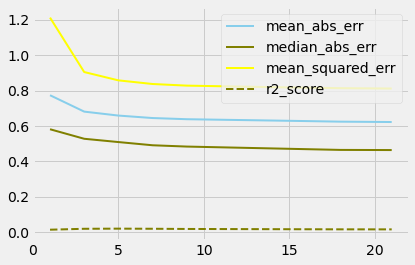

In [ ]:
plt.plot( strategies, results_mae, marker='', markerfacecolor='blue', color='skyblue', linewidth=2, label='mean_abs_err')
plt.plot( strategies, results_medae, marker='', color='olive', linewidth=2, label='median_abs_err')
plt.plot( strategies, results_mse, marker='', color='yellow', linewidth=2, label='mean_squared_err')
plt.plot( strategies, results_r2, marker='', color='olive', linewidth=2, linestyle='dashed', label="r2_score")
plt.legend()

In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=231,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_knn = gs.best_estimator_
b_gs_knn.fit(X_train, y_train)
y_pred = b_gs_knn.predict(X_test)
test_model(b_gs_knn)

mean_absolute_error: 0.5483631874111675
median_absolute_error: 0.3436709020389868
mean_squared_error: 0.7036458247519601
r2_score: 0.14654315503008164


##MICE

Multivariate feature imputation - Multivariate imputation by chained equations (MICE)
A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_mice = data.copy()

mice_imputer = IterativeImputer()
df_mice['Rating'] = mice_imputer.fit_transform(df_mice[['Rating']])
df_mice['Size'] = mice_imputer.fit_transform(df_mice[['Size']])

df_mice.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

In [ ]:
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_num,Genres_num
0,ART_AND_DESIGN,4.1,159.0,19000000.0,10000.0,0,0.0,1,Art & Design,0,9
1,ART_AND_DESIGN,3.9,967.0,14000000.0,500000.0,0,0.0,1,Art & Design;Pretend Play,0,12
2,ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000.0,0,0.0,1,Art & Design,0,9
3,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000.0,0,0.0,4,Art & Design,0,9
4,ART_AND_DESIGN,4.3,967.0,2800000.0,100000.0,0,0.0,1,Art & Design;Creativity,0,11


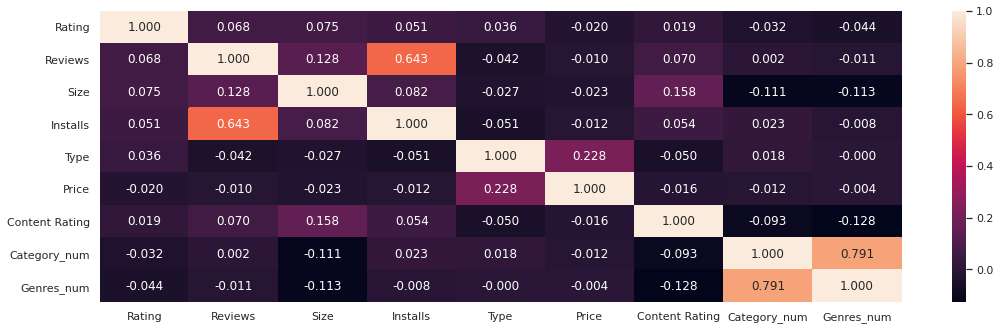

In [ ]:
plt.figure(figsize = (16,5))
sns.heatmap(df_mice.corr(), annot=True, fmt='.3f')

In [ ]:
X_mice = df_mice.drop(["Rating", "Genres", "Category", "Genres_num", "Category_num"], axis=1)
y_mice = df_mice["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X_mice, y_mice,
                            test_size=0.2, random_state=88888888)

lin_mice = LinearRegression()
lin_mice.fit(X_train, y_train)
test_model(lin_mice)

mean_absolute_error: 0.3043151145481133
median_absolute_error: 0.21937504429889865
mean_squared_error: 0.21200504385208094
r2_score: 0.010525774039341407


In [ ]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=221,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
b_gs_mice = gs.best_estimator_
b_gs_mice.fit(X_train, y_train)
y_pred = b_gs_mice.predict(X_test)
test_model(b_gs_mice)

mean_absolute_error: 0.2950345987847198
median_absolute_error: 0.17882052441534868
mean_squared_error: 0.21351252615715124
r2_score: 0.003490022154119532


In [ ]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='black')
        plt.show()    

In [ ]:
# Модели
regr_models = {'Del NaN Rows': {'model': lin_dropna, 'X': X_dropna, 'y': y_dropna},
               'Mean':{'model': lin_mean, 'X': X_mean, 'y': y_mean},
               'Median':{'model': lin_median, 'X': X_median, 'y': y_median},
               'Mode':{'model': lin_mode, 'X': X_mode, 'y': y_mode},
               'Ffill':{'model': lin_ffill, 'X': X_ffill, 'y': y_ffill},
               'Set 0':{'model': lin_zero, 'X': X_zero, 'y': y_zero},
               'Clustering k-Means': {'model': lin_clust, 'X': X_clust, 'y': y_clust},
               'Clustering GMM': {'model': lin_clust_gmm, 'X': X_clust_gmm, 'y': y_clust_gmm},
               'regression': {'model': lin_regr, 'X': X_regr, 'y': y_regr},
               'KNN': {'model': lin_knn, 'X': X_knn, 'y': y_knn},
               'MICE': {'model': lin_mice, 'X': X_mice, 'y': y_mice}
              }

In [ ]:
regrMetricLogger = MetricLogger()

In [ ]:
def regr_train_model(model_name, model, X, y, regrMetricLogger):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.2, random_state=88888888)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MedAE', model_name, medae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)     
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MedAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(medae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [ ]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model['model'], model['X'], model['y'], regrMetricLogger)

*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.377, MedAE=0.281, MSE=0.292, R2=0.011
*****************************************************
*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.304, MedAE=0.221, MSE=0.212, R2=0.012
*****************************************************
*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.312, MedAE=0.212, MSE=0.213, R2=0.01
*****************************************************
*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.322, MedAE=0.215, MSE=0.217, R2=0.008
*****************************************************
*****************************************************
LinearRegressio

In [ ]:
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MedAE', 'MSE', 'R2'], dtype=object)

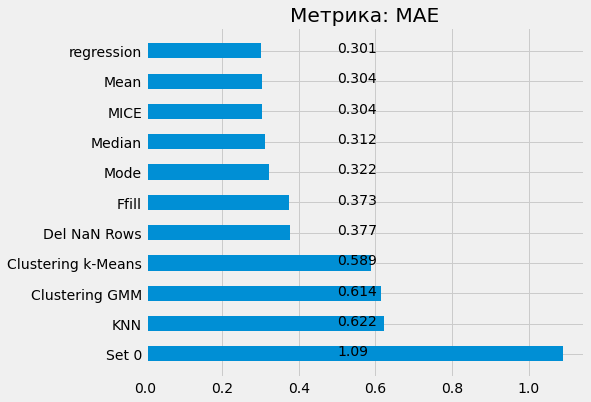

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', 
                      ascending=False, figsize=(7, 6))

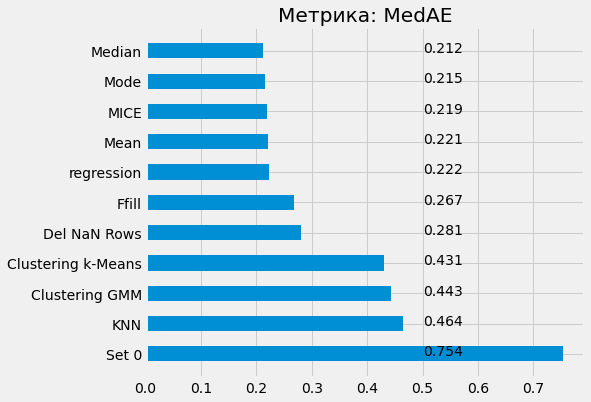

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'MedAE', 'MedAE', 
                      ascending=False, figsize=(7, 6))

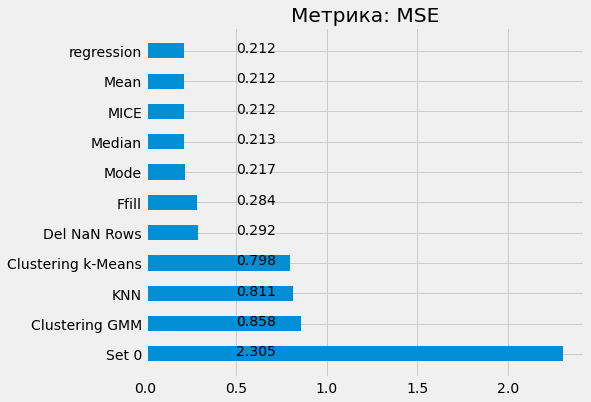

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', 
                      ascending=False, figsize=(7, 6))

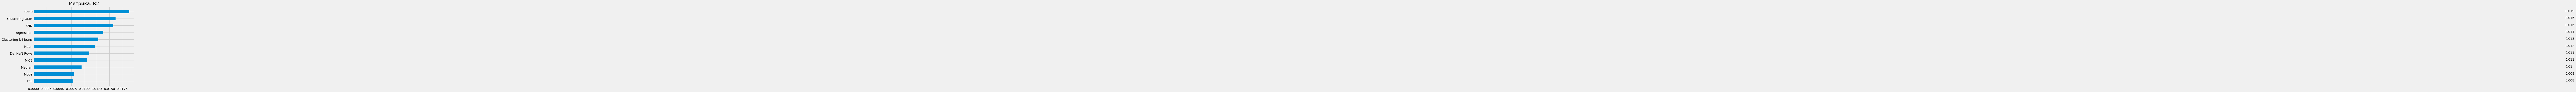

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2',
                      ascending=True, figsize=(7, 6))  

Тесты на модели линейной регрессии показывают, что стратегии заполнения пропусков с помощью среднего значения и регрессии подходящие для данного надора данных.
Для сравнения точности различных моделей линейной регрессии лучше использовать MSE, чем R2.
Однако метрика median absolute error определяет, что самая правильная техника - медиана, также по критерию r2 медиана точнее среднего значения и регрессии.

In [ ]:
# Модели
regr_models = {'Del NaN Rows': {'model': b_gs_dropna, 'X': X_dropna, 'y': y_dropna},
               'Mean':{'model': b_gs_mean, 'X': X_mean, 'y': y_mean},
               'Median':{'model': b_gs_median, 'X': X_median, 'y': y_median},
               'Mode':{'model': b_gs_mode, 'X': X_mode, 'y': y_mode},
               'Ffill':{'model': b_gs_ffill, 'X': X_ffill, 'y': y_ffill},
               'Set 0':{'model': b_gs_zero, 'X': X_zero, 'y': y_zero},
               'Clustering k-Means': {'model': b_gs_clust, 'X': X_clust, 'y': y_clust},
               'Clustering GMM': {'model': b_gs_clust_gmm, 'X': X_clust_gmm, 'y': y_clust_gmm},
               'regression': {'model': b_gs_regr, 'X': X_regr, 'y': y_regr},
               'KNN': {'model': b_gs_knn, 'X': X_knn, 'y': y_knn},
               'MICE': {'model': b_gs_mice, 'X': X_mice, 'y': y_mice}
              }

In [ ]:
regrMetricLogger = MetricLogger()

In [ ]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model['model'], model['X'], model['y'], regrMetricLogger)

*****************************************************
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=241,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

MAE=0.332, MedAE=0.223, MSE=0.261, R2=0.116
*****************************************************
*****************************************************
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=201,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

MAE=0.276, MedAE=0.174, MSE=0.185, R2=0.137
*****************************************************
*****************************************************
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, m

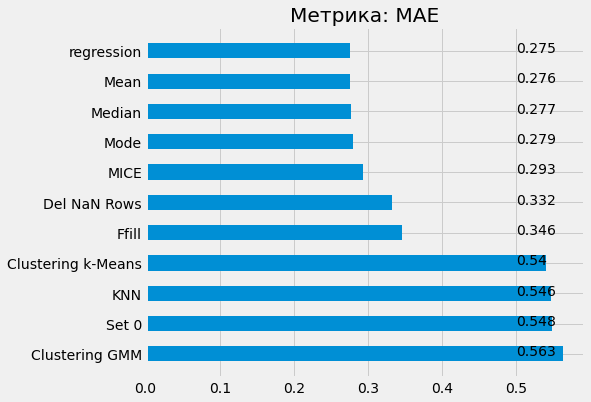

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', 
                      ascending=False, figsize=(7, 6))

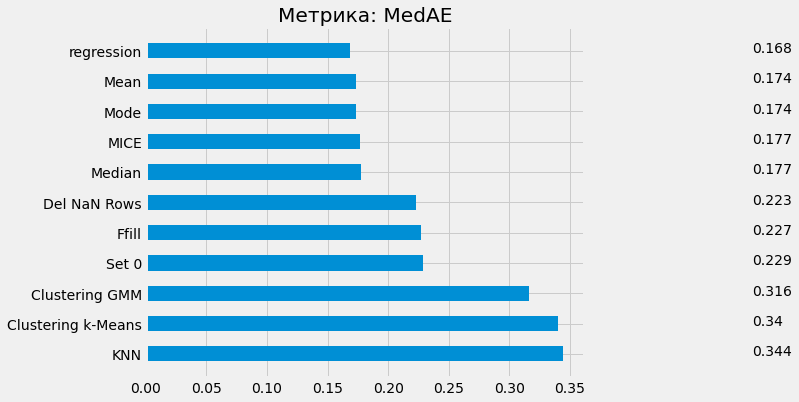

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'MedAE', 'MedAE', 
                      ascending=False, figsize=(7, 6))

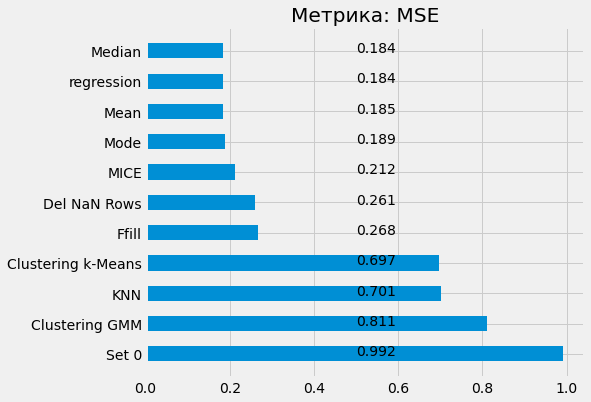

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', 
                      ascending=False, figsize=(7, 6))

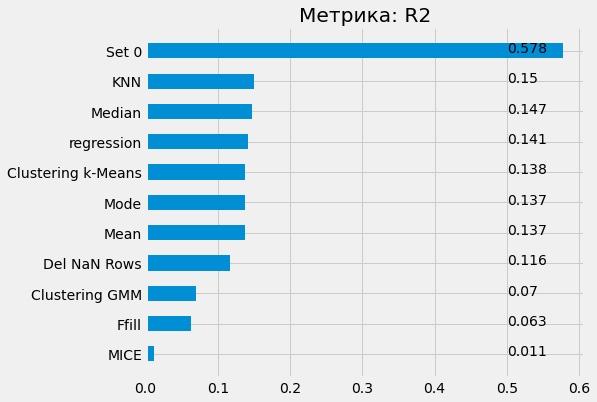

In [ ]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2',
                      ascending=True, figsize=(7, 6))  

Тесты на модели Bagging показывают, что стратегии заполнения пропусков с помощью среднего значения и регрессии подходящие для данного надора данных.

Отдам предпочтение при заполнении пропусков в числовых признаках среднему значению(mean).